# 概要
### これは何か
- 離散的に観測される時空間データ（$u(x^{obs_i}, t)$）を補間して連続的な時空間の分布（$u(x, t)$）を再現するプログラム
  - ./main.cpp: $u(x^{obs_i}, t)$ →$u(x, t)$を実現するプログラム
    - ./lib/Basic_include_file_set.h: 共通で利用するヘッダーファイルを定義
    - ./lib/basic.h(pp): ファイルの読み書きなどの基本操作を定義
    - ./lib/matrix_algebra.h(pp): 行列・テンソル操作を定義
    - ./lib/fft.h(pp): フーリエ変換関数を定義
    - ./lib/method.h(pp): 機械学習モデル（マルチアウトプットOLS/LASSO）を定義
    - ./lib/cluster.h(pp): 機械学習モデル構築に適した形に観測データを処理するクラスを定義
    - ./lib/element.h(pp): 空間分布の表現に適した形に機械学習の予測結果を処理するクラスを定義
  - ./ImagingDiscreteData.ipynb: main.cppの結果を可視化するノートブック

### どのように作ったのか
- 以下の流れでデータを処理
  - $u(x^{obs_i}, t)$ →$u(x^{obs_i}, \omega)$: フーリエ変換で周波数領域に変換。高周波は必要に応じてカット
  - $u(x^{obs_i}, \omega)$ →$u(x, \omega)$: 周波数領域で空間分布を推定するためのモデルを構築＆推定の実行
  - $u(x, \omega)$:  →$u(x, t)$: フーリエ逆変換で周波数領域から時間領域に変換


# サンプルデータ生成

In [1]:
# カレントディレクトリに移動
%cd /content/drive/MyDrive/Analytics/ImagingGroundMotion/

/content/drive/MyDrive/Analytics/ImagingGroundMotion


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# 観測点データの生成
df_position = pd.DataFrame({
    'x':np.random.uniform(0, 1, size=220),
    'y':np.random.uniform(0, 1, size=220),
    'z':np.random.uniform(0, 0.01, size=220)})

df_position.to_csv('./input/position.csv', index=None, header=None)

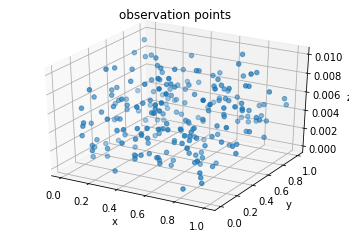

In [14]:
# 観測点データの可視化
# df_position=pd.read_csv('./input/position.csv', header=None, names=['x', 'y', 'z'])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(df_position.x, df_position.y, df_position.z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("observation points")
plt.show()

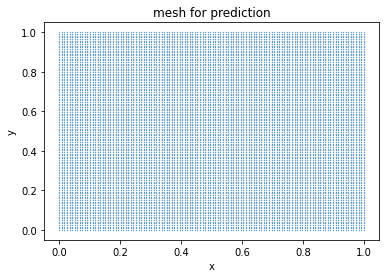

In [15]:
# 予測対象のメッシュデータ生成
xlist = np.linspace(0, 1, 120)
ylist = np.linspace(0, 1, 120)
xyzlist = []
for x in xlist:
  for y in ylist:
    xyzlist.append({'x': x, 'y': y, 'z': 0})

df_xyz = pd.DataFrame(xyzlist)
df_xyz.to_csv('./input/grid.csv', index=None, header=None)

# メッシュの生成状況の可視化
df_xyz[['x', 'y']].plot.scatter('x', 'y', s=0.1)
plt.title('mesh for prediction')
plt.show()

In [16]:
# 観測データの生成
def wave(x, y, z):
  ux = np.array([np.sin(10*x*y*(z+1)+0.1*t) for t in range(2**10)])
  uy = np.array([np.cos(10*x*y*(z+1)+0.1*t) for t in range(2**10)])
  uz = np.array([np.sin(10*x*y*(z+1)+0.1*t)*np.sin(x*y*(z+1)+0.1*t) for t in range(2**10)])
  return (ux, uy, uz)

# データの保存
u_list = [wave(x, y, z) for x, y, z in zip(df_position.x, df_position.y, df_position.z)]
for i, u in enumerate(u_list):
  df_u = pd.DataFrame(data=np.array(u).T, columns=['x', 'y', 'z'])
  df_u.to_csv('./input/ut/'+str(i)+'.csv', index=None, header=None)

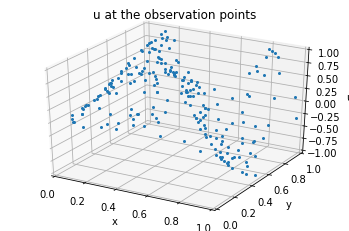

In [27]:
# 観測データの可視化
import matplotlib.animation as animation
from IPython.display import HTML

nfr = 50 # Number of frames
fps = 10 # Frame per sec

xs = []
ys = []
zs = []
for t in range(400):
    xs.append(df_position.x)
    ys.append(df_position.y)
    zs.append(np.array(u_list)[:,0,t]) # x, y, z の3方向の成分があるがここではx方向の成分のみ可視化


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct, = ax.plot([], [], [], "o", markersize=2)
def update(ifrm, xa, ya, za):
    sct.set_data(xa[ifrm], ya[ifrm])
    sct.set_3d_properties(za[ifrm])
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(-1,1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title("u at the observation points")

ani = animation.FuncAnimation(fig, update, nfr, fargs=(xs,ys,zs), interval=500/fps)

HTML(ani.to_html5_video())

In [28]:
ani.save('observation.gif', writer='pillow', fps=fps)

# main.cppの実行

In [40]:
# main.cppのコンパイル＆実行
!g++ -I./lib main.cpp & ./a.out

finish initialization of cluster
finish making cluster & computing beta
finish calcuration of ut at all the elements
finish transformation to image data
finish saving data


# 実行結果の可視化

In [19]:
# 出力データの読み込み
images = [pd.read_csv('./output/'+str(i)+'.csv', header=None).to_numpy() for i in range(400)]

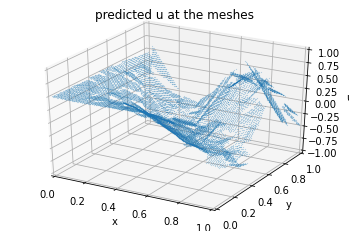

In [24]:
# 予測結果の可視化
import matplotlib.animation as animation
from IPython.display import HTML

nfr = 50 # Number of frames
fps = 10 # Frame per sec

xs = []
ys = []
zs = []
for t in range(100):
    xs.append(images[t][:,0])
    ys.append(images[t][:,1])
    zs.append(images[t][:,2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct, = ax.plot([], [], [], "o", markersize=0.1)
def update(ifrm, xa, ya, za):
    sct.set_data(xa[ifrm], ya[ifrm])
    sct.set_3d_properties(za[ifrm])
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(-1,1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title("predicted u at the meshes")

ani = animation.FuncAnimation(fig, update, nfr, fargs=(xs,ys,zs), interval=500/fps)

HTML(ani.to_html5_video())

In [26]:
ani.save('imaging.gif', writer='pillow', fps=fps)